# Assignment 8: Transfer Learning
_Word Representations and Language Models (WS 24/25)_

Group Members: Buket Sak, Ludmila Bajuk, Alexander Weyhe
***

In this week's assignment, you will learn how to use language models in scenarios where labeled training data is limited. You may find that, for a given language or domain, there is no dataset of suitable size. Transfer learning allows us to apply the latent information learned by models trained in high resource languages or domains to downstream tasks without the need for a lot of task-specific annotated data.

* First, you will learn how to use a model that is trained on one language to make predictions for data in another language.
* Second, you will experiment with in-context learning. Here the task description and a varying amount of training examples is passed to the model alongside the actual input while making predictions.

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#FFF2CC;border-color:#D6B656;color:#856404">
<b>How to Submit the Assignment</b>

Please work on this assignment in groups of two or three. Make sure to add your names to this files header. After completion, share this assignment with me (<b>Julian Schelb - <a target="blank" href="https://www.kaggle.com/julianschelb">https://www.kaggle.com/julianschelb</a></b>) due Wednesday, 15th January, 12:00. Use the upper-right share button as instructed in the tutorial. In ILIAS, submit this notebook as response to Assignment 09. You can download this notebook using the "Download Notebook" option in the "File" menu.
</div>

In [1]:
!pip install seqeval rouge evaluate -q --root-user-action=ignore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.3 MB/s eta 0:00:00


In [2]:
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    TrainingArguments,
    Trainer,
    logging,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
)
from datasets import load_dataset
import evaluate  # Replacing load_metric with evaluate for metric calculation
from sklearn.metrics import f1_score
from random import randrange
from pprint import pprint
from rouge import Rouge
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import numpy as np
import torch
import re

# Initialize the metric using the evaluate library
metric = evaluate.load("seqeval")

# Set logging verbosity
logging.set_verbosity_error()

# Add progress bar functionality
tqdm.pandas()

## Task 1: Transfer Learning

Transfer learning allows a model to be trained on data from a source setting and applied to a different target setting. The model we want to use is trained on English text. We will fine-tune it with texts in the target language to use it with text in a different language. The model should be able to use some of the latent information learned during pretraining. Settings involving low resource languages with not enough data available to properly pretrain do especially benefit from such an approach.

**Named Entity Recognition as Seq-to-Seq Problem:**

NER is commonly modeled as a token classification task using sequence-to-sequence models. The commonly used IOB notation accounts for multi-token entities by labeling them as either the beginning of an entity (B) or the inside token of an entity (I). Non-entity tokens are labeled as O. Extending this notation by adding the abbreviated entity type as a suffix to form a joint label is common. Examples are B-PER for the beginning of a person or I-LOC for an inside token of a location’s name.


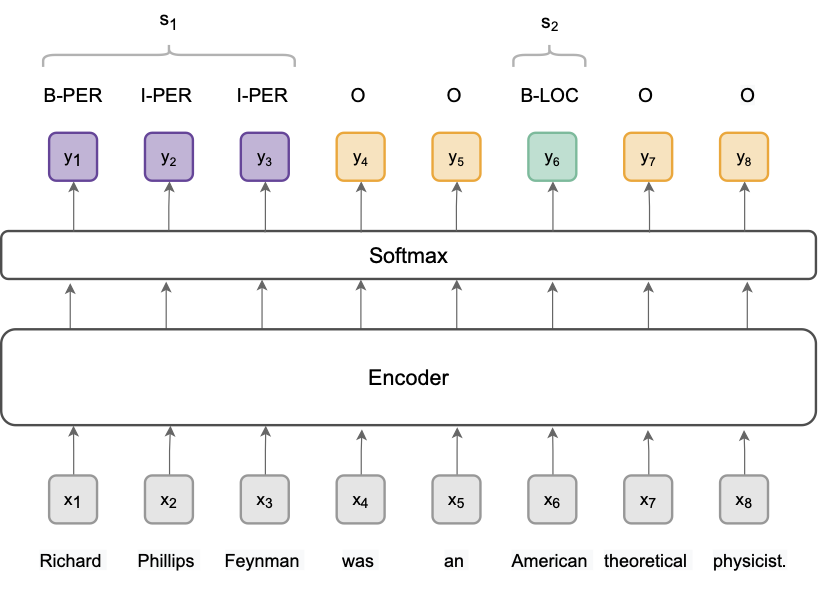


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Fine-tune a Model</b> 
</div>

First, we want to obtain a performance baseline by measuring how well a model which was pretrained and fine-tuned with English data performs on detecting entities in German texts. Please implement the following tasks:

1. Load the [roberta-base](https://huggingface.co/roberta-base) model and tokenizer. 
2. Load the English portion of the [europarl dataset](https://www.kaggle.com/datasets/julianschelb/euro-parl-ner).
3. Tokenize the train and test set.
4. Fine-tune the model for token classification using the train set, by completing the provided functions.
    * Use the [AutoTokenizer()](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) and  [AutoModelforTokenClassification()](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForTokenClassification) classes provided by the transformers package. 
    * You can use this [example](https://github.com/julianschelb/roberta-ner-multilingual) implementation as a guide. Train for at least 8 epochs.
5. Use the English test set to confirm that your model was successfully fine-tuned.  
6. Use the Italian, Spanish or German test set to evaluate the model's performance in a different language.  
7. Report the model's performance by printing the F1 score.

In [3]:
# Mapping from class name to class ID
label_ids = {"O": 0, "B-ORG": 1, "I-ORG": 2, 
             "B-PER": 3, "I-PER": 4, 
             "B-LOC": 5, "I-LOC": 6, 
             "B-MISC": 7, "I-MISC": 8}

# Mapping from class ID to class Iname
label_names = {0: "O", 1: "B-ORG", 2: "I-ORG",  
               3: "B-PER", 4: "I-PER" , 
               5: "B-LOC", 6: "I-LOC",  
               7: "B-MISC", 8: "I-MISC"}

In [4]:
# Load the model & tokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_ids))  # Number of labels

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [5]:
# Load dataset
dataset_train = load_dataset("json", data_files="/kaggle/input/en-europarl_iob_train.jsonl", split = "train")
dataset_valid = load_dataset("json", data_files="/kaggle/input/en-europarl_iob_test.jsonl", split = "train")
dataset_test = load_dataset("json", data_files="/kaggle/input/de-europarl_iob_test.jsonl", split = "train")

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
print(dataset_train.column_names)

['tokens', 'labels']


In [7]:
# Tokenize the dataset

def tokenizeInputs(inputs):
    
    tokenized = tokenizer(inputs["tokens"], max_length = 128, truncation=True, is_split_into_words=True, add_special_tokens=False)
    
    word_ids = tokenized.word_ids()
    ner_tags = inputs["labels"]
    labels = [ner_tags[word_id] for word_id in word_ids]
    tokenized["labels"] = labels
    return tokenized


In [8]:
dataset_train = dataset_train.map(tokenizeInputs)
dataset_valid = dataset_valid.map(tokenizeInputs)
dataset_test = dataset_test.map(tokenizeInputs)

# Data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/268 [00:00<?, ? examples/s]

Map:   0%|          | 0/283 [00:00<?, ? examples/s]

In [9]:
# Inspect the first example to check input_ids and labels length
print("Input IDs:", len(dataset_train[0]["input_ids"])) 
print("Labels:", len(dataset_train[0]["labels"])) 

Input IDs: 46
Labels: 46


In [10]:
# Check a sample
print(dataset_train[0])  # Inspect the first tokenized example
print("Input IDs length:", len(dataset_train[0]["input_ids"]))
print("Labels length:", len(dataset_train[0]["labels"]))

{'tokens': ['Resumption', 'of', 'the', 'session', 'I', 'declare', 'resumed', 'the', 'session', 'of', 'the', 'European', 'Parliament', 'adjourned', 'on', 'Friday', '17', 'December', '1999', ',', 'and', 'I', 'would', 'like', 'once', 'again', 'to', 'wish', 'you', 'a', 'happy', 'new', 'year', 'in', 'the', 'hope', 'that', 'you', 'enjoyed', 'a', 'pleasant', 'festive', 'period', '.'], 'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'input_ids': [4787, 21236, 9, 5, 1852, 38, 10152, 13168, 5, 1852, 9, 5, 796, 3879, 16649, 196, 15, 273, 601, 719, 6193, 2156, 8, 38, 74, 101, 683, 456, 7, 2813, 47, 10, 1372, 92, 76, 11, 5, 1034, 14, 47, 3776, 10, 16219, 12298, 675, 479], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Input IDs length: 46
Labels length: 46


In [11]:
# Fine-tune the Model

def finetuneModel(tokenizer, model, dataset_train, epochs=2,  batch_size=16):
# Define the training arguments
    training_args = TrainingArguments(
        output_dir="./results",            
        num_train_epochs=epochs,           
        per_device_train_batch_size=batch_size,  
        per_device_eval_batch_size=batch_size,   
        logging_dir="./logs",              
        logging_steps=10,                  
        eval_strategy="steps",       
        save_strategy="steps",             
        report_to = "none"
  
    )
    # Load seqeval metric
    metric = evaluate.load("seqeval")    
    # Define the compute_metrics function
    def compute_metrics(eval_preds):
        predictions, labels = eval_preds
        predictions = np.argmax(predictions, axis=-1)
        # Remove -100 (padding) from labels and predictions
        true_labels = [
            [label_names[l] for l in label if l != -100] for label in labels
        ]
        true_predictions = [
            [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        # Compute the metrics
        results = metric.compute(predictions=true_predictions, references=true_labels)
    
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }
    # Initialize Trainer
    trainer = Trainer(
        model=model,                          
        args=training_args,                   
        train_dataset=dataset_train,          
        eval_dataset=dataset_valid,           
        data_collator=data_collator,
        compute_metrics=compute_metrics      
     )
    
    # Start the training
    trainer.train()
    
    # Save the final model
    model.save_pretrained("./final_model")
    tokenizer.save_pretrained("./final_model")
    
    return model, trainer

# Call the function to fine-tune the model
model, trainer = finetuneModel(tokenizer, model, dataset_train, 8, 16)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7784, 'grad_norm': 0.9709681868553162, 'learning_rate': 4.609375e-05, 'epoch': 0.625}


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2778641879558563, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.9395447194924742, 'eval_runtime': 0.9401, 'eval_samples_per_second': 285.073, 'eval_steps_per_second': 9.573, 'epoch': 0.625}
{'loss': 0.2365, 'grad_norm': 2.9454963207244873, 'learning_rate': 4.21875e-05, 'epoch': 1.25}
{'eval_loss': 0.196041077375412, 'eval_precision': 0.21652421652421652, 'eval_recall': 0.2585034013605442, 'eval_f1': 0.23565891472868217, 'eval_accuracy': 0.9438984948376664, 'eval_runtime': 0.9428, 'eval_samples_per_second': 284.245, 'eval_steps_per_second': 9.546, 'epoch': 1.25}
{'loss': 0.2109, 'grad_norm': 1.7933850288391113, 'learning_rate': 3.828125e-05, 'epoch': 1.875}
{'eval_loss': 0.15311488509178162, 'eval_precision': 0.26057906458797325, 'eval_recall': 0.3979591836734694, 'eval_f1': 0.3149394347240915, 'eval_accuracy': 0.950366961064809, 'eval_runtime': 0.9349, 'eval_samples_per_second': 286.663, 'eval_steps_per_second': 9.627, 'epoch': 1.875}
{'l

In [12]:
# Evaluate the model using the test set

def getPredictions(trainer, dataset_test):
    # Get predictions from the model
    predictions, labels, _ = trainer.predict(dataset_test)
    
    # Convert logits to predicted labels (by taking argmax)
    predictions = np.argmax(predictions, axis=-1)
    
    return predictions, labels

predictions_en, labels_en = getPredictions(trainer, dataset_valid)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [19]:
predictions_en[0], labels_en[0]

(array([0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]),
 array([   0,    0,    0,    1,    2,    0,    0,    0,    1,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100]))

In [20]:
unique_labels = np.unique(labels_en)
print(unique_labels)

[-100    0    1    2    3    4    5    6    7    8]


In [21]:
# Calculate performance metrics
from sklearn.metrics import classification_report

# Ensure you have 9 class names corresponding to indices 0-8
label_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']

def calculateMetrics(labels, predictions, label_names):
        # Flatten multi-output labels and predictions
    labels_flat = np.array(labels).flatten()
    predictions_flat = np.array(predictions).flatten()
    # Generate a classification report which includes precision, recall, and F1-score
    report = classification_report(labels_flat, predictions_flat, target_names=label_names)
    
    return report

results_en = calculateMetrics(labels_en, predictions_en, label_names)
print(results_en)

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00     16885
     Class 1       0.31      0.99      0.47      7553
     Class 2       0.80      0.81      0.81       108
     Class 3       0.81      0.96      0.88        69
     Class 4       0.57      0.98      0.72        66
     Class 5       0.00      0.00      0.00        23
     Class 6       0.61      0.79      0.69        34
     Class 7       0.50      0.11      0.18         9
     Class 8       0.50      0.38      0.43        86
     Class 9       0.33      0.58      0.42        91

    accuracy                           0.31     24924
   macro avg       0.44      0.56      0.46     24924
weighted avg       0.10      0.31      0.15     24924



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# For comparison calculate the calculate performance metrics for the EN test set
predictions_de, labels_de = getPredictions(trainer, dataset_test)
results_de = calculateMetrics(labels_de, predictions_de, label_names)
print(results_de)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 7 seems not to be NE tag.
  warnings.warn('{} seems not to be NE

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00     18740
     Class 1       0.46      0.92      0.61     16337
     Class 2       0.64      0.27      0.38       336
     Class 3       0.29      0.05      0.08       103
     Class 4       0.06      0.86      0.11        74
     Class 5       0.00      0.00      0.00        23
     Class 6       0.23      0.58      0.32        71
     Class 7       0.00      0.00      0.00         5
     Class 8       0.09      0.37      0.15       373
     Class 9       0.04      0.14      0.06       162

    accuracy                           0.42     36224
   macro avg       0.18      0.32      0.17     36224
weighted avg       0.21      0.42      0.28     36224



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Fine-Tune With a Different Language</b> 
</div>

Finally, we test how well the model performs for similar languages. Your task is to fine-tune the model with one of the other languages included in the dataset. Choose the same language you used as the test set in the previous step [Europarl dataset](https://www.kaggle.com/datasets/julianschelb/euro-parl-ner) to make a comparison possible. You can reuse the code from the previous step. Please report the f1 score as well.

* How does the model perform even though it was trained on a different language? 
* Was the model  able to transfer some of the information learned during pretraining?


In [23]:
# Load datasets
dataset_train_de = load_dataset("json", data_files="/kaggle/input/de-europarl_iob_train.jsonl", split = "train")
dataset_test_de = load_dataset("json", data_files="/kaggle/input/de-europarl_iob_test.jsonl", split = "train")

Generating train split: 0 examples [00:00, ? examples/s]

In [24]:
# Tokenize the dataset
dataset_train_de = dataset_train_de.map(tokenizeInputs)
dataset_test_de = dataset_test_de.map(tokenizeInputs)

# Fine-tune the model with the German dataset
model_de, trainer_de = finetuneModel(tokenizer, model, dataset_train_de, epochs=8, batch_size=16)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/283 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4303, 'grad_norm': 1.6135988235473633, 'learning_rate': 4.609375e-05, 'epoch': 0.625}


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 5 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 7 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_

{'eval_loss': 0.13386330008506775, 'eval_precision': 0.6328800988875154, 'eval_recall': 0.6564102564102564, 'eval_f1': 0.6444304594084329, 'eval_accuracy': 0.9599452668242319, 'eval_runtime': 1.0217, 'eval_samples_per_second': 262.314, 'eval_steps_per_second': 8.809, 'epoch': 0.625}
{'loss': 0.1877, 'grad_norm': 1.8226219415664673, 'learning_rate': 4.21875e-05, 'epoch': 1.25}


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.11635460704565048, 'eval_precision': 0.7004279600570613, 'eval_recall': 0.6294871794871795, 'eval_f1': 0.6630654962862931, 'eval_accuracy': 0.9642990421694241, 'eval_runtime': 1.029, 'eval_samples_per_second': 260.458, 'eval_steps_per_second': 8.747, 'epoch': 1.25}
{'loss': 0.1788, 'grad_norm': 2.0646302700042725, 'learning_rate': 3.828125e-05, 'epoch': 1.875}
{'eval_loss': 0.1091422289609909, 'eval_precision': 0.7481481481481481, 'eval_recall': 0.6474358974358975, 'eval_f1': 0.6941580756013745, 'eval_accuracy': 0.9681552431894515, 'eval_runtime': 1.0335, 'eval_samples_per_second': 259.321, 'eval_steps_per_second': 8.709, 'epoch': 1.875}
{'loss': 0.1315, 'grad_norm': 5.596105098724365, 'learning_rate': 3.4375e-05, 'epoch': 2.5}
{'eval_loss': 0.1112964004278183, 'eval_precision': 0.711864406779661, 'eval_recall': 0.6461538461538462, 'eval_f1': 0.6774193548387097, 'eval_accuracy': 0.9655429779823361, 'eval_runtime': 1.0541, 'eval_samples_per_second': 254.237, 'eval_steps_

In [26]:
# Evaluate the model using the English test set
predictions_en_de, labels_en_de = getPredictions(trainer_de, dataset_test)
# Ensure you have 9 class names corresponding to indices 0-8
label_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']
# Calculate performance metrics for the German fine-tuned model on English test data
results_en_de = calculateMetrics(labels_en_de, predictions_en_de, label_names)
print("Evaluation of German fine-tuned model on English test set:")
print(results_en_de)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 7 seems not to be NE tag.
  warnings.warn('{} seems not to be NE

Evaluation of German fine-tuned model on English test set:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00     18740
     Class 1       0.46      0.99      0.63     16337
     Class 2       0.59      0.78      0.67       336
     Class 3       0.35      0.60      0.44       103
     Class 4       0.57      0.78      0.66        74
     Class 5       1.00      0.17      0.30        23
     Class 6       0.69      0.51      0.59        71
     Class 7       0.17      0.60      0.26         5
     Class 8       0.34      0.43      0.38       373
     Class 9       0.19      0.28      0.23       162

    accuracy                           0.46     36224
   macro avg       0.44      0.52      0.42     36224
weighted avg       0.22      0.46      0.30     36224



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# Evaluate the model using the test set

# Get predictions for the test set
predictions_test, labels_test = getPredictions(trainer, dataset_test)

# Calculate performance metrics
results_test = calculateMetrics(labels_test, predictions_test, label_names)
print("Test Set Results:")
print(results_test)

# Calculate F1 score
#f1 = f1_score(labels_test.flatten(), predictions_test.flatten(), average='weighted') 
#print(f"Weighted F1 score: {f1}")

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Class 7 seems not to be NE tag.
  warnings.warn('{} seems not to be NE

Test Set Results:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00     18740
     Class 1       0.46      0.99      0.63     16337
     Class 2       0.59      0.78      0.67       336
     Class 3       0.35      0.60      0.44       103
     Class 4       0.57      0.78      0.66        74
     Class 5       1.00      0.17      0.30        23
     Class 6       0.69      0.51      0.59        71
     Class 7       0.17      0.60      0.26         5
     Class 8       0.34      0.43      0.38       373
     Class 9       0.19      0.28      0.23       162

    accuracy                           0.46     36224
   macro avg       0.44      0.52      0.42     36224
weighted avg       0.22      0.46      0.30     36224



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Your Interpretation:**


***

## Task 2: In-Context Learning

Training a model is difficult in many supervised Machine Learning applications due to the limited amount of labeled data.  It's possible to work around this limitation by not fine-tuning a model at all, but including the task description along with a varying number of training examples as context while making predictions (as demonstrated in ["Language Models are Few-Shot Learners"](https://arxiv.org/pdf/2005.14165.pdf)). The assumption is that the model can infer the task from the included context without being fine-tuned for that specific task. Depending on how many training examples are included in the context, we distinguish between three scenarios:

* **Zero-Shot (0S)**: only the task description and no training examples are included.
* **One-Shot (1S)**: a single training example is included.
* **Few-Shot (FS)**: k training examples are included (usually k < 100).

This article about ["Few-shot learning in practice"](https://huggingface.co/blog/few-shot-learning-gpt-neo-and-inference-api) provides more background information and an interactive web demonstration.



<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Load Dataset and Model</b> 
</div>

For this assignment, we will use a dataset created to evaluate models for Named Entity Recognition (NER). NER is the task of identifying real-world entities in free text and labeling them as one out of a set of predefined entity types (e.g., persons, organizations, locations). The [original corpus](https://aclanthology.org/2005.mtsummit-papers.11/) consists of parallel text from the proceedings of the European Parliament in multiple languages. Here we use an [annotated version](https://aclanthology.org/L18-1557/) where entities are already tagged.

Please implement the following tasks:
1. Import the csv file "en-europarl.csv" from [this dataset](https://www.kaggle.com/datasets/julianschelb/euro-parl-ner), which contains sentences with entities already tagged.
2. Load the [FLAN-T5-large ](https://huggingface.co/google/flan-t5-large) model, which we will use in subsequent tasks.


In [28]:
# Load the dataset
data = pd.read_csv("/kaggle/input/en-europarl.csv")
data.head()

,sentence,type,label
0,Resumption of the session I declare resumed th...,organization,European Parliament
1,"In the meantime , I should like to observe a m...",organization,European Union
2,( The House rose and observed a minute ' s sil...,organization,House
3,You will be aware from the press and televisio...,location,Sri Lanka
4,"If the House agrees , I shall do as Mr Evans h...",person,Evans


In [29]:
# Load the model & tokenizer
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Context Construction</b> 
</div>

Your task is to implement a function which uses the non-fine-tuned [FLAN-T5-large ](https://huggingface.co/google/flan-t5-large) to detect named entities in a given sentence. To achieve this, you need to construct the input sequence by combining $k$ complete training examples and the final incomplete example for the model to predict. 

Please complete the function *constructContext()* which ...

* takes as paramater a sentence, the entity type, and $k$ (number of training examples).
* returns the constructed context.

The final input sequence should be constructed as follows:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg" style="undefined;table-layout: fixed; width: 658px">
<colgroup>
<col style="width: 201px">
<col style="width: 457px">
</colgroup>
<thead>
  <tr>
    <th class="tg-0pky">Section</th>
    <th class="tg-0pky">Example Value</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal;text-decoration:none">k Complete Training Examples</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal;text-decoration:none">C: I should be very grateful , Mrs Schroedter , if you would actually include this proposed amendment. </span><br><span style="font-weight:400;font-style:normal;text-decoration:none">Q: What person is mentioned?</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">A: Schroedter</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">###</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">C: Mr Bernié is not to blame for this as it was a matter for the previous committee. </span><br><span style="font-weight:400;font-style:normal;text-decoration:none">Q: What person is mentioned?</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">A: Bernié</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">###</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">C: The Commission must track down the illegal aid. </span><br><span style="font-weight:400;font-style:normal;text-decoration:none">Q: What organization is mentioned?</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">A: Commission</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">###</span><br></td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal;text-decoration:none">Incomplete Example</span></td>
    <td class="tg-0pky"><span style="font-weight:400;font-style:normal;text-decoration:none">C: I should like to observe a minute ' s silence , on behalf of all the victims in the the European Union. </span><br><span style="font-weight:400;font-style:normal;text-decoration:none">Q: What organization is mentioned?</span><br><span style="font-weight:400;font-style:normal;text-decoration:none">A:</span><br></td>
  </tr>
</tbody>
</table>


In [30]:
# Complete this function
def constructContext(k, sentence, entity_type, training_examples):
    """Returns the input sequence for in-context learning."""

    context = ""
    
    # Loop over the k training examples
    for i in range(min(k, len(training_examples))):  # Handle cases where k > len(training_examples)
        example = training_examples[i]
        # Add the training example to the context
        context += f"Extract {example['entity_type']} entities from the sentence: '{example['sentence']}'\n"
        context += f"Answer: {example['entities']}\n\n"
    
    # Add the target sentence to the context
    context += f"Extract {entity_type} entities from the sentence: '{sentence}'\n"
    context += "Answer:"
    
    return context

In [31]:
    training_examples = [
    {'entity_type': 'person', 'sentence': 'I should be very grateful, Mrs Schroedter, if you would actually include this proposed amendment.', 'entities': 'Schroedter'},
    {'entity_type': 'person', 'sentence': 'Mr Bernié is not to blame for this as it was a matter for the previous committee.', 'entities': 'Bernié'},
    {'entity_type': 'organization', 'sentence': 'The Commission must track down the illegal aid.', 'entities': 'Commission'}
]

In [32]:
# Test your implementation
context = constructContext(3, data.iloc[3]["sentence"], data.iloc[3]["type"], training_examples)
print(context)

Extract person entities from the sentence: 'I should be very grateful, Mrs Schroedter, if you would actually include this proposed amendment.'
Answer: Schroedter

Extract person entities from the sentence: 'Mr Bernié is not to blame for this as it was a matter for the previous committee.'
Answer: Bernié

Extract organization entities from the sentence: 'The Commission must track down the illegal aid.'
Answer: Commission

Extract location entities from the sentence: 'You will be aware from the press and television that there have been a number of bomb explosions and killings in Sri Lanka . '
Answer:


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 3: Named Entity Recognition</b> 
</div>

By passing the constructed context to GPT-NEO, the model should be able to infer that the entity in the last incomplete example is the desired next token to generate. The examples provided in the [model card](https://huggingface.co/google/flan-t5-large) and the [documentation](https://huggingface.co/docs/transformers/model_doc/t5) on huggingface.co should be helpful resources. 

Please complete the function *predictEntity()* which ...

* takes a constructed context as parameter,
* generates n additional tokens (e.g. by using the [.generate()](https://huggingface.co/docs/transformers/main_classes/text_generation) method),
* extracts the answer from the generated text,
* and finally returns the answer predicted by the model.

In [33]:
def predictEntity(context, max_new_tokens = 2):
    """Identifies entities using in-context learning."""

# Encode the context into input IDs
    inputs = tokenizer(context, padding=True, truncation=True, return_tensors="pt")
    
    # Generate the output tokens
    outputs = model.generate(inputs["input_ids"], max_length=inputs["input_ids"].shape[1] + max_new_tokens, 
                             num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)
    
    # Decode the generated tokens back into text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract the predicted entity after "Answer:"
    predicted_entity = generated_text.split("Answer:")[-1].strip()
    
    return predicted_entity

In [34]:
prediction = predictEntity(context)
print("Prediction:", prediction)
print("True Answer:", data.iloc[3]["label"])

Prediction: Sri Lanka
True Answer: Sri Lanka


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 4: Evaluate the Model’s In-Context Learning Performance</b> 
</div>

Your next task is to evaluate the model's performance in different in-context learning scenarios. Please implement the following steps:

1. Evaluate the model in a Zero-Shot (k = 0), One-Shot (k = 1) and Few-Shot (k = 3) scenario:
    * First, construct contexts using *constructContext()*.
    * Second, pass the contexts to *predictEntity()* to obtain the answer.
2. Display 10 results for each of the three scenarios.
3. Calculate the [F1](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) and [ROUGE-L](https://pypi.org/project/rouge/) score for each of the three scenarios. 
4. Plot the results with k as x-axis and f1 score as y-axis and briefly summarize the results.

In [35]:
# Evaluate with k = 0
k_zero_shot_results = []
for i in range(10):  # Display 10 results
    context_zero_shot = constructContext(0, data.iloc[i]["sentence"], data.iloc[i]["type"], training_examples)
    prediction_zero_shot = predictEntity(context_zero_shot)
    k_zero_shot_results.append({"sentence": data.iloc[i]["sentence"], "prediction": prediction_zero_shot, "entity": data.iloc[i]["label"]})


In [36]:
# Print 10 results for k = 0
for i, result in enumerate(k_zero_shot_results):
    print(f"Zero-Shot {i+1}: Sentence: {result['sentence']}, Prediction: {result['prediction']}, True Answer: {result['entity']}")

Zero-Shot 1: Sentence: Resumption of the session I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999 , and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period . , Prediction: European Parliament, True Answer: European Parliament
Zero-Shot 2: Sentence: In the meantime , I should like to observe a minute ' s silence , as a number of Members have requested , on behalf of all the victims concerned , particularly those of the terrible storms , in the various countries of the European Union . , Prediction: European Union, True Answer: European Union
Zero-Shot 3: Sentence: ( The House rose and observed a minute ' s silence ) Madam President , on a point of order . , Prediction: House, True Answer: House
Zero-Shot 4: Sentence: You will be aware from the press and television that there have been a number of bomb explosions and killings in Sri Lanka . , Prediction: Sri Lanka, True Answer: Sri Lanka


In [37]:
# Evaluate with k = 1
k_one_shot_results = []
for i in range(10):  # Display 10 results
    context_one_shot = constructContext(1, data.iloc[i]["sentence"], data.iloc[i]["type"], training_examples)
    prediction_one_shot = predictEntity(context_one_shot)
    k_one_shot_results.append({"sentence": data.iloc[i]["sentence"], "prediction": prediction_one_shot, "entity": data.iloc[i]["label"]})

In [38]:
# Print 10 results for k = 1
for i, result in enumerate(k_one_shot_results):
    print(f"One-Shot {i+1}: Sentence: {result['sentence']}, Prediction: {result['prediction']}, True Answer: {result['entity']}")

One-Shot 1: Sentence: Resumption of the session I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999 , and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period . , Prediction: European Parliament, True Answer: European Parliament
One-Shot 2: Sentence: In the meantime , I should like to observe a minute ' s silence , as a number of Members have requested , on behalf of all the victims concerned , particularly those of the terrible storms , in the various countries of the European Union . , Prediction: European Union, True Answer: European Union
One-Shot 3: Sentence: ( The House rose and observed a minute ' s silence ) Madam President , on a point of order . , Prediction: The House, True Answer: House
One-Shot 4: Sentence: You will be aware from the press and television that there have been a number of bomb explosions and killings in Sri Lanka . , Prediction: Sri Lanka, True Answer: Sri Lanka


In [39]:
# Evaluate with k = 3
k_few_shot_results = []
for i in range(10):  # Display 10 results
    context_few_shot = constructContext(3, data.iloc[i]["sentence"], data.iloc[i]["type"], training_examples)
    prediction_few_shot = predictEntity(context_few_shot)
    k_few_shot_results.append({"sentence": data.iloc[i]["sentence"], "prediction": prediction_few_shot, "entity": data.iloc[i]["label"]})

In [40]:
# Print 10 results for k = 3
for i, result in enumerate(k_few_shot_results):
    print(f"Few-Shot {i+1}: Sentence: {result['sentence']}, Prediction: {result['prediction']}, True Answer: {result['entity']}")

Few-Shot 1: Sentence: Resumption of the session I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999 , and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period . , Prediction: European Parliament, True Answer: European Parliament
Few-Shot 2: Sentence: In the meantime , I should like to observe a minute ' s silence , as a number of Members have requested , on behalf of all the victims concerned , particularly those of the terrible storms , in the various countries of the European Union . , Prediction: European Union, True Answer: European Union
Few-Shot 3: Sentence: ( The House rose and observed a minute ' s silence ) Madam President , on a point of order . , Prediction: The House, True Answer: House
Few-Shot 4: Sentence: You will be aware from the press and television that there have been a number of bomb explosions and killings in Sri Lanka . , Prediction: Sri Lanka, True Answer: Sri Lanka


In [41]:
# Extract true labels and predictions for each scenario
true_labels_zero_shot = [result["entity"] for result in k_zero_shot_results]
predictions_zero_shot = [result["prediction"] for result in k_zero_shot_results]

true_labels_one_shot = [result["entity"] for result in k_one_shot_results]
predictions_one_shot = [result["prediction"] for result in k_one_shot_results]

true_labels_few_shot = [result["entity"] for result in k_few_shot_results]
predictions_few_shot = [result["prediction"] for result in k_few_shot_results]


# Calculate F1 scores for each scenario with the 'macro' average for multiclass classification
f1_zero_shot = f1_score(true_labels_zero_shot, predictions_zero_shot, average='macro')
f1_one_shot = f1_score(true_labels_one_shot, predictions_one_shot, average='macro')
f1_few_shot = f1_score(true_labels_few_shot, predictions_few_shot, average='macro')

print(f"F1 Score (Zero-Shot): {f1_zero_shot}")
print(f"F1 Score (One-Shot): {f1_one_shot}")
print(f"F1 Score (Few-Shot): {f1_few_shot}")

F1 Score (Zero-Shot): 0.5
F1 Score (One-Shot): 0.43589743589743585
F1 Score (Few-Shot): 0.43589743589743585


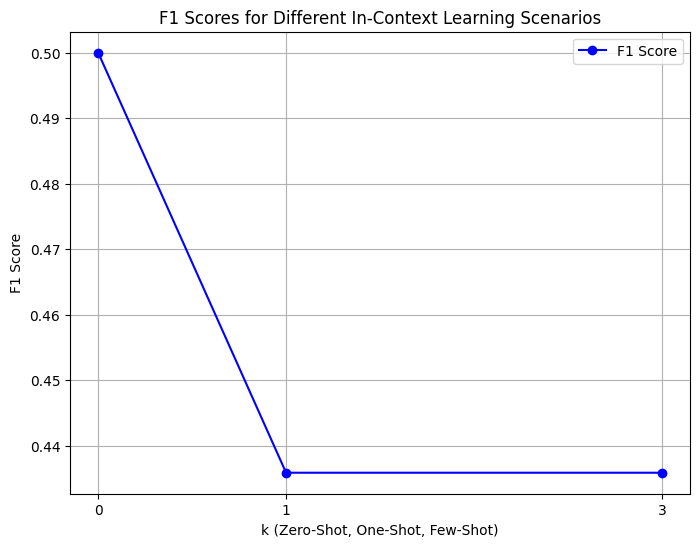

In [42]:
import matplotlib.pyplot as plt
# Plot F1 scores 
k_values = [0, 1, 3]
f1_scores = [f1_zero_shot, f1_one_shot, f1_few_shot]

plt.figure(figsize=(8, 6))
plt.plot(k_values, f1_scores, marker='o', linestyle='-', color='b', label='F1 Score')
plt.xlabel("k (Zero-Shot, One-Shot, Few-Shot)")
plt.ylabel("F1 Score")
plt.title("F1 Scores for Different In-Context Learning Scenarios")
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

In [43]:
rouge = Rouge()
# Calculate ROUGE-L for each set of predictions
rouge_scores_zero_shot = rouge.get_scores(predictions_zero_shot, true_labels_zero_shot, avg=True)
rouge_scores_one_shot = rouge.get_scores(predictions_one_shot, true_labels_one_shot, avg=True)
rouge_scores_few_shot = rouge.get_scores(predictions_few_shot, true_labels_few_shot, avg=True)
# Extract ROUGE-L scores
rouge_l_zero_shot = rouge_scores_zero_shot['rouge-l']['f']
rouge_l_one_shot = rouge_scores_one_shot['rouge-l']['f']
rouge_l_few_shot = rouge_scores_few_shot['rouge-l']['f']

# Print the ROUGE-L scores
print(f"ROUGE-L Score (Zero-Shot): {rouge_l_zero_shot}")
print(f"ROUGE-L Score (One-Shot): {rouge_l_one_shot}")
print(f"ROUGE-L Score (Few-Shot): {rouge_l_few_shot}")

ROUGE-L Score (Zero-Shot): 0.8999999951666666
ROUGE-L Score (One-Shot): 0.8666666618888887
ROUGE-L Score (Few-Shot): 0.8666666618888887


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

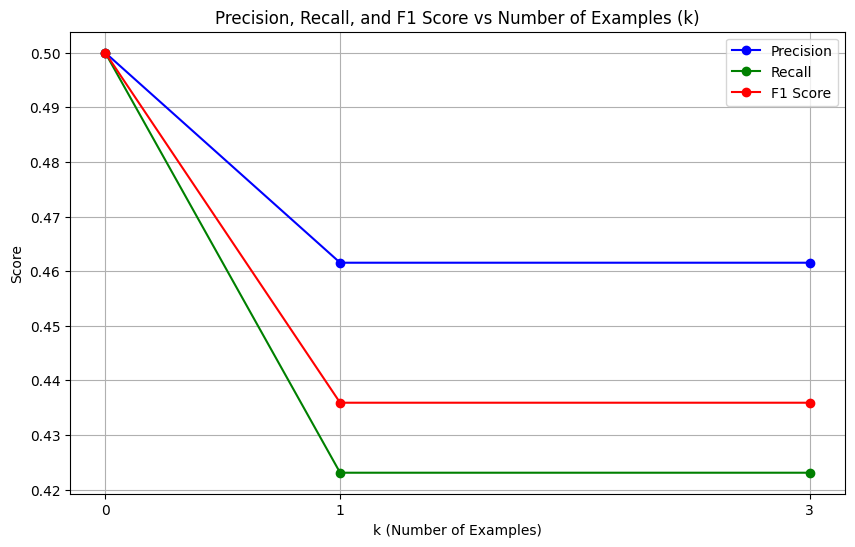

In [44]:
from sklearn.metrics import precision_recall_fscore_support
# Create separate lists for recall, precision, and f-measure
# Calculate precision, recall, and F1 score for each k scenario
precision_zero_shot, recall_zero_shot, f1_zero_shot, _ = precision_recall_fscore_support(true_labels_zero_shot, predictions_zero_shot, average='macro')
precision_one_shot, recall_one_shot, f1_one_shot, _ = precision_recall_fscore_support(true_labels_one_shot, predictions_one_shot, average='macro')
precision_few_shot, recall_few_shot, f1_few_shot, _ = precision_recall_fscore_support(true_labels_few_shot, predictions_few_shot, average='macro')

# Create separate lists for recall, precision, and F1 score
precisions = [precision_zero_shot, precision_one_shot, precision_few_shot]
recalls = [recall_zero_shot, recall_one_shot, recall_few_shot]
f1_scores = [f1_zero_shot, f1_one_shot, f1_few_shot]

# Create a DataFrame for plotting
metrics_df = pd.DataFrame({
    'k': [0, 1, 3],
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

# Plot the data
plt.figure(figsize=(10, 6))

# Plot Precision
plt.plot(metrics_df['k'], metrics_df['Precision'], marker='o', label='Precision', color='blue')

# Plot Recall
plt.plot(metrics_df['k'], metrics_df['Recall'], marker='o', label='Recall', color='green')

# Plot F1 Score
plt.plot(metrics_df['k'], metrics_df['F1 Score'], marker='o', label='F1 Score', color='red')

# Customize plot
plt.xlabel('k (Number of Examples)')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Number of Examples (k)')
plt.xticks(metrics_df['k'])  # Ensure that k-values are used as x-ticks
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

**Your Interpretation:**



In [45]:
print("Predictions Zero-Shot:", predictions_zero_shot[:10])
print("True Labels Zero-Shot:", true_labels_zero_shot[:10])

print("Predictions One-Shot:", predictions_one_shot[:10])
print("True Labels One-Shot:", true_labels_one_shot[:10])

print("Predictions Few-Shot:", predictions_few_shot[:10])
print("True Labels Few-Shot:", true_labels_few_shot[:10])

Predictions Zero-Shot: ['European Parliament', 'European Union', 'House', 'Sri Lanka', 'Mr Evans', 'Mr Hicks', 'Mr Segni', 'House', 'Russia', 'Alexander Nikitin']
True Labels Zero-Shot: ['European Parliament', 'European Union', 'House', 'Sri Lanka', 'Evans', 'Hicks', 'Segni', 'House', 'Russia', 'Alexander Nikitin']
Predictions One-Shot: ['European Parliament', 'European Union', 'The House', 'Sri Lanka', 'Mr Evans', 'Mr Hicks', 'Mr Segni', 'House', 'Russia', 'Alexander Nikitin']
True Labels One-Shot: ['European Parliament', 'European Union', 'House', 'Sri Lanka', 'Evans', 'Hicks', 'Segni', 'House', 'Russia', 'Alexander Nikitin']
Predictions Few-Shot: ['European Parliament', 'European Union', 'The House', 'Sri Lanka', 'Mr. Evans', 'Mr Hicks', 'Mr Segni', 'House', 'Russia', 'Alexander Nikitin']
True Labels Few-Shot: ['European Parliament', 'European Union', 'House', 'Sri Lanka', 'Evans', 'Hicks', 'Segni', 'House', 'Russia', 'Alexander Nikitin']
